<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/Milestone_Project_2_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skimlit

The purpose is to build a NLP Model to read medicatl abstracts easier


In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Get Data
We need to get the data from github

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.09 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the pubmed_20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#Start our experiments using the 20k dataset with numbers replaced by "@" sign.
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames=[data_dir + filename for filename in os.listdir(data_dir)]

In [6]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

beome one with the data....We need to visualize

Let's write a function to read in all the lines of a target text file

In [7]:
#Function to read the lines of a document
def get_lines(filename):

  """
  Reads filename ( text file name )and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath
  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    lines=f.readlines()
    return lines



In [8]:
#let's read in the training lines
train_lines=get_lines(data_dir+"train.txt")

In [9]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

Let's think about how we want the data to look

How can we the data be best represented
```
[{'line_number': 0,
    'target' : BACKGROUND,
    'text':"Emotional Eating..."
    'total_lines':11}]
```

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictinaries of abstract line data

  Takes in filename, read it's contens and sorts through each line,
  extracting things like target label, the text of the sentence, how many sentences are in the current abstract, etc
  """
  input_lines=get_lines(filename)# Get all lines fro filename
  abstract_lines="" #Create an empty abstract
  abstract_samples=[]# Create an empty list of abstracts

  #Loop through each line in target file
  for line in input_lines:
    #print(line)
    if line.startswith("###"): #Check the line is an ID line...the abstract is starting
      abstract_id=line
      abstract_lines="" #Reset the abstract string if the line is ID Line
    elif line.isspace(): #Check if the line is a new line
      abstract_line_split=abstract_lines.splitlines()


      #iterate each line in a single abstract and keep count of which line we are on
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")# Split the target label from the text

        line_data['target']=target_text_split[0]
        line_data['text']=target_text_split[1].lower()
        line_data['line_number']=abstract_line_number
        line_data['total_lines']=len(abstract_line_split)-1# How many total lines are there in target abstract
        abstract_samples.append(line_data)

    else: #if the above conditions aren't fulfilled, the lines containes a labelled sentence
      abstract_lines+=line

  return abstract_samples


In [12]:
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 383 ms, sys: 108 ms, total: 491 ms
Wall time: 496 ms


(180040, 30212, 30135)

In [13]:
#Check the first abstract of our training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of list of dicts, how about we turn it into dataframe to further visualize it


In [14]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [15]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [16]:
#What is the spread of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

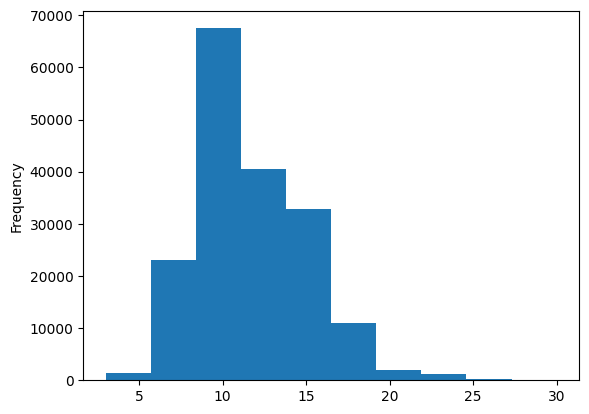

In [17]:
#Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get the list of sentences so that we can work with just the text

In [18]:
#Convert abstract text lines into list
train_sentences=train_df['text'].tolist()
val_sentences=val_df['text'].tolist()
test_sentences=test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML required Numeric labels)



In [21]:
#One hot encoding labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse=False)

In [22]:
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [25]:
val_labels_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

Extract labels("target colums ") and encode them into integer_op_not_supported

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
test_labels_encoded=label_encoder.transform(test_df['target'].to_numpy())
val_labels_encoded=label_encoder.transform(val_df['target'].to_numpy())

In [27]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [28]:
#Get class names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a seties of modelling experiments

We'll be trying out a bunch of different models to see which one works best...starting with the baseline.
Tf-IDF multinomial naive bayes classifier

### Model 0: Baseline


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("classifier", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [33]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [34]:
# Make some predictions using the baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [35]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [36]:
### Download the helper FUnction Script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-19 18:15:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-19 18:15:03 (56.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [37]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [38]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the text for the Deep Learning Model

Before we start building deep models, we need to create vectorization and embedding layers

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [42]:
#How long is each sentence on average

sent_lens=[len(sentence.split()) for sentence in train_sentences]

In [45]:
avg_sent_len=np.mean(sent_lens)
sent_lens, avg_sent_len

([49,
  27,
  15,
  14,
  35,
  29,
  30,
  55,
  36,
  8,
  32,
  39,
  12,
  26,
  33,
  40,
  22,
  23,
  27,
  26,
  27,
  34,
  41,
  18,
  9,
  23,
  59,
  16,
  18,
  22,
  17,
  51,
  8,
  17,
  16,
  5,
  21,
  4,
  42,
  50,
  11,
  19,
  20,
  29,
  36,
  44,
  39,
  25,
  19,
  24,
  19,
  14,
  11,
  18,
  16,
  26,
  16,
  18,
  38,
  28,
  21,
  18,
  22,
  9,
  37,
  6,
  32,
  21,
  26,
  25,
  18,
  21,
  20,
  12,
  26,
  16,
  23,
  19,
  16,
  39,
  19,
  14,
  37,
  34,
  15,
  47,
  26,
  87,
  17,
  29,
  31,
  13,
  37,
  28,
  35,
  60,
  64,
  66,
  8,
  12,
  17,
  40,
  43,
  37,
  47,
  6,
  40,
  64,
  20,
  32,
  53,
  16,
  30,
  54,
  51,
  19,
  28,
  32,
  36,
  40,
  13,
  25,
  30,
  23,
  17,
  15,
  20,
  50,
  12,
  16,
  27,
  24,
  10,
  24,
  5,
  14,
  19,
  32,
  13,
  21,
  23,
  10,
  11,
  17,
  12,
  21,
  21,
  15,
  17,
  21,
  18,
  40,
  33,
  21,
  41,
  21,
  13,
  29,
  28,
  13,
  44,
  20,
  31,
  8,
  29,
  13,
  116,
  27,
  

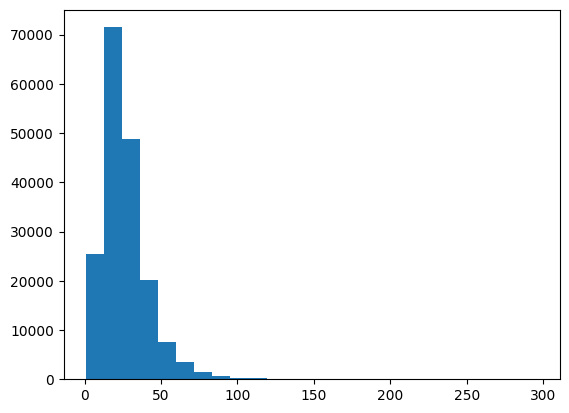

In [51]:
#What does the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [53]:
# How long of a sentence length covers 95& of example?
output_seq_len=int(np.percentile(sent_lens, 95))
output_seq_len

55

In [55]:
max(sent_lens)

296